# AI-Compass: Anomaly & Gap Detection
### Strategic Rationale
One of the highest values of a human consultant is pointing out the "Elephant in the room"-those inconsistencies where a client's reality doesn't match their ambition. 

**This notebook implements automated "Structural Gap" detection:**
1.  **Statistical Thresholding (Z-Scores)**: We identify dimension pairs where the "Maturity Gap" is significantly different from the average peer.
2.  **Blind Spot Identification**: If a company has high 'Tech' but very low 'Strategy', we flag this as a risk factor, even if their total score is 'average'.
3.  **Consulting-Ready Feedback**: We translate these statistical outliers into professional, actionable warnings.


In [13]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from dotenv import load_dotenv
import psycopg2

# Visualization
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# DB Connection
load_dotenv()
db_url = os.getenv("DATABASE_URL")
conn = psycopg2.connect(db_url)
print("✓ Connected to Database")


✓ Connected to Database


## 1. Data Loading & Normalization
We fetch the data, excluding 'General Psychology', and scale it to the **1-5 maturity scale**.


In [14]:
query = """
SELECT 
    r.company_id,
    d.dimension_name,
    q.header as tactical_theme,
    q.weight as question_weight,
    a.answer_weight
FROM response_items ri
JOIN responses r ON r.response_id = ri.response_id
JOIN questions q ON q.question_id = ri.question_id
JOIN dimensions d ON d.dimension_id = q.dimension_id
JOIN answers a ON a.answer_id = ri.answers[1]
WHERE d.dimension_name != 'General Psychology'
"""

df_raw = pd.read_sql(query, conn)

# 1. Dimension Level Features (for Z-Scores/Anomalies)
df_features = df_raw.groupby(['company_id', 'dimension_name'])['answer_weight'].mean().reset_index()
df_features = df_features.pivot(index='company_id', columns='dimension_name', values='answer_weight').fillna(0)
df_features = 1 + 4 * (df_features - df_features.min()) / (df_features.max() - df_features.min())

# 2. Question Level Features (for Weighted Gaps)
df_raw['weighted_gap'] = df_raw['question_weight'] * (5.0 - df_raw['answer_weight'])

print(f"Dataset prepared with {len(df_features)} companies and {len(df_raw)} total response items.")
df_features.head()


/var/folders/s4/gzyj3_ks2_s0smrmyspjtc2h0000gn/T/ipykernel_11195/1425525192.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(query, conn)


Dataset prepared with 500 companies and 13500 total response items.


dimension_name,Data Readiness & Literacy,Governance & Compliance,People & Culture,Processes & Scaling,Strategy & Business Vision,Tech Infrastructure,Use Cases & Business Value
company_id,,,,,,,
3,2.703704,1.800000,3.00,2.25,2.75,2.787234,2.25
4,3.296296,2.066667,2.25,1.75,2.00,2.872340,1.75
6,3.000000,1.533333,2.00,2.00,1.75,2.787234,1.75
9,2.481481,1.800000,1.25,2.00,2.25,1.595745,2.75
10,3.000000,2.600000,2.25,3.00,2.50,1.255319,1.75


## 2. Statistical Gap Analysis
We define "Risky Gaps" - these are pairs of dimensions that *should* grow together but are far apart for certain users.


In [15]:
risk_pairs = [
    ('Tech Infrastructure', 'People & Culture'),
    ('Tech Infrastructure', 'Strategy & Business Vision'),
    ('Data Readiness & Literacy', 'Use Cases & Business Value'),
    ('Processes & Scaling', 'Governance & Compliance')
]

for p1, p2 in risk_pairs:
    col_name = f'gap_{p1[:4]}_{p2[:4]}'
    df_features[col_name] = df_features[p1] - df_features[p2]

gap_cols = [c for c in df_features.columns if c.startswith('gap_')]
df_zscores = df_features[gap_cols].apply(zscore)
print("Gap Z-Scores calculated.")


Gap Z-Scores calculated.


## 3. Detecting the "Blind Spot"
We flag a company if any of its Dimension Gaps have a **Z-Score > 1.5**.


In [16]:
def detect_strategic_gaps(company_id):
    findings = []
    company_z = df_zscores.loc[company_id]
    anomalies = company_z[np.abs(company_z) > 1.5].sort_values(key=abs, ascending=False)
    
    for gap_name, val in anomalies.items():
        if len(findings) >= 2: break
        if "Tech_Peop" in gap_name: d1, d2 = 'Tech Infrastructure', 'People & Culture'
        elif "Tech_Stra" in gap_name: d1, d2 = 'Tech Infrastructure', 'Strategy & Business Vision'
        elif "Data_Use " in gap_name or "Data_Use" in gap_name: d1, d2 = 'Data Readiness & Literacy', 'Use Cases & Business Value'
        elif "Proc_Gove" in gap_name: d1, d2 = 'Processes & Scaling', 'Governance & Compliance'
        else: continue
            
        s1, s2 = df_features.loc[company_id, d1], df_features.loc[company_id, d2]
        if s1 > s2:
            findings.append(f"🔴 **Critical Infrastructure Imbalance**: Your **{d1}** ({s1:.1f}) is ahead of your **{d2}** ({s2:.1f}). Strategic risk: Wasted investment and organizational friction.")
        else:
            findings.append(f"🟠 **Strategic Adoption Lag**: Your **{d2}** ({s2:.1f}) maturity is ready for scaling, but currently bottlenecked by your **{d1}** ({s1:.1f}). Focus on technical enablement.")

    if len(findings) < 2:
        company_items = df_raw[df_raw['company_id'] == company_id].sort_values(['question_weight', 'weighted_gap'], ascending=False)
        for _, row in company_items.iterrows():
            if len(findings) >= 2: break
            desc = f"📈 **High-ROI Opportunity**: Mature your **{row['tactical_theme']}** (Strategic Impact Weight: {row['question_weight']:.1f}). Currently at stage {row['answer_weight']:.1f}, this is your highest leverage path to AI maturity."
            if not any(row['tactical_theme'] in f for f in findings):
                findings.append(desc)
    return findings


## 4. EXECUTIVE BRIEFING (LLM-READY)

In [17]:
def synthesize_executive_briefing(company_id):
    findings = detect_strategic_gaps(company_id)
    return f"""
    ### 🎖️ Executive Briefing (Draft)
    
    Our analysis reveals a critical strategic pattern: **{findings[0].split('**')[1] if '**' in findings[0] else findings[0]}**. 
    In the context of the SME landscape, this indicates that your growth path should prioritize 
    **{findings[1].split('**')[1] if '**' in findings[1] else findings[1]}** to unlock ROI.
    
    By addressing these specific 'Silent Killers' now, you ensure that future technology investments 
    translate into measurable business value.
    """

cid = df_features.index[42]
print(synthesize_executive_briefing(cid))



    ### 🎖️ Executive Briefing (Draft)

    Our analysis reveals a critical strategic pattern: **High-ROI Opportunity**. 
    In the context of the SME landscape, this indicates that your growth path should prioritize 
    **High-ROI Opportunity** to unlock ROI.

    By addressing these specific 'Silent Killers' now, you ensure that future technology investments 
    translate into measurable business value.
    


## 4. Visualizing Polarization

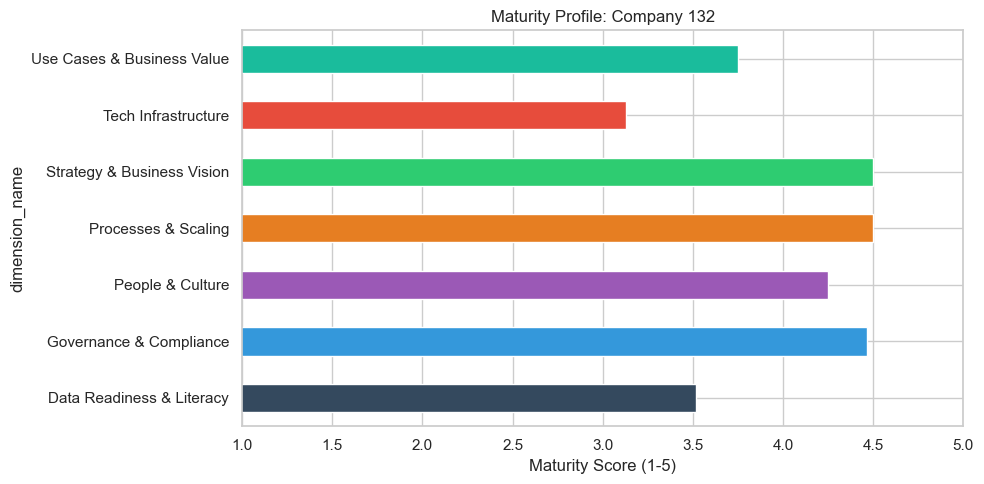

In [18]:
def plot_imbalance(company_id):
    scores = df_features.loc[company_id, [c for c in df_features.columns if not c.startswith('gap_')]].drop('rounded_avg', errors='ignore')
    plt.figure(figsize=(10, 5))
    scores.plot(kind='barh', color=['#34495e', '#3498db', '#9b59b6', '#e67e22', '#2ecc71', '#e74c3c', '#1abc9c'])
    plt.title(f'Maturity Profile: Company {company_id}')
    plt.xlabel('Maturity Score (1-5)')
    plt.xlim(1, 5)
    plt.tight_layout()
    plt.show()

cid = df_features.index[42]
plot_imbalance(cid)


## 5. Strategic Conclusion & Risk Mitigation

### 1. The Multi-Dimensional Maturity Lens
Single-score maturity models are often misleading. A company might have a "B" grade overall, but a "Structural Polarization" (e.g., High Tech / Low Strategy) that makes them extremely vulnerable to failed projects. Automated anomaly detection allows consultants to spot these **silent killers** before they drain budgets.

### 2. The Relationship between Technical & Organizational Enablement
Our analysis shows that **Tech Infrastructure** and **People & Culture** are the most critical decoupled pair. Technology without literacy leads to friction; literacy without technology leads to frustration.

### 3. Immediate Recommendation
Flagged anomalies should be the **first topic** in any executive workshop. Resolving these fundamental structural gaps often yields higher ROI than starting a new AI pilot, as it builds the "Maturity Foundation" required for sustainable scaling.
